# Exploring MovieLens : A Deep and Wide model


In [1]:
import pandas as pd
import numpy as np 

from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import stats
from scipy.spatial.distance import pdist

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from itertools import cycle

import string

from collections import Counter

from keras.layers.embeddings import Embedding
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from keras.regularizers import l1, l2

from keras.layers.recurrent import GRU, LSTM

from keras import backend as K

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


## Importing the data

In [2]:
org_ratings = pd.read_csv('data/MovieLens/ratings.csv')
org_movies = pd.read_csv('data/MovieLens/movies.csv')
org_ratings.head(), org_movies.head()

(   userId  movieId  rating   timestamp
 0       1       31     2.5  1260759144
 1       1     1029     3.0  1260759179
 2       1     1061     3.0  1260759182
 3       1     1129     2.0  1260759185
 4       1     1172     4.0  1260759205,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [3]:
users = org_ratings.userId.unique()
movies = org_ratings.movieId.unique()
rating = org_ratings.rating.unique()
len(users), len(movies), len(rating)

(671, 9066, 10)

In [4]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
movieidx2id = {i:o for i,o in enumerate(movies)}

In [5]:
new_ratings = org_ratings.copy()

new_ratings.movieId = org_ratings.movieId.apply(lambda x: movieid2idx[x])
new_ratings.userId = org_ratings.userId.apply(lambda x: userid2idx[x])

In [6]:
new_ratings = new_ratings.drop('timestamp', axis = 1)

In [7]:
msk = np.random.rand(len(new_ratings)) < 0.8

train = new_ratings[msk]
valid = new_ratings[~msk]

In [8]:
print(train.shape, valid.shape)
print(train.head())

((80194, 3), (19810, 3))
   userId  movieId  rating
0       0        0     2.5
1       0        1     3.0
2       0        2     3.0
4       0        4     4.0
5       0        5     2.0


## Training a wide an deep neural net 

In [39]:
# Multi layer LSTM model

user_input = Input(shape=(1,), dtype='float32', name='user_input')
movie_input = Input(shape = (1,), dtype = 'float32', name = 'movie_input')

#The 'deep' part of the neural net
user_embed = Embedding(len(users), 55, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 55, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.8)(x)
BatchNormalization()
x = LSTM(40)(x)
x = Dropout(0.8)(x)
BatchNormalization()

#The 'wide' part of the neural net 
y = merge([user_input, movie_input], mode = 'concat', name = 'wide_layer')

y = Dense(2)(y)
y = Dropout(0.8)(y)
BatchNormalization()

final = merge([x, y], mode = 'concat', name = 'final_merge')
BatchNormalization()

preds = Dense(1)(final)

deepwide_nn = Model([user_input, movie_input], preds)
deepwide_nn.compile(Adam(0.001), loss='mse')

In [37]:
deepwide_nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_23 (Embedding)         (None, 1, 55)         36905       user_input[0][0]                 
____________________________________________________________________________________________________
embedding_24 (Embedding)         (None, 1, 55)         498630      movie_input[0][0]                
___________________________________________________________________________________________

In [40]:
deepwide_hist = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/10
80194/80194 [==============================] - 13s - loss: 577008.0162 - val_loss: 135.3444
Epoch 2/10
80194/80194 [==============================] - 13s - loss: 194.3416 - val_loss: 27.0442
Epoch 3/10
80194/80194 [==============================] - 13s - loss: 19.8109 - val_loss: 5.8146
Epoch 4/10
80194/80194 [==============================] - 13s - loss: 6.7377 - val_loss: 2.4411
Epoch 5/10
80194/80194 [==============================] - 13s - loss: 4.0549 - val_loss: 1.7613
Epoch 6/10
80194/80194 [==============================] - 13s - loss: 3.0887 - val_loss: 1.4030
Epoch 7/10
80194/80194 [==============================] - 13s - loss: 2.6257 - val_loss: 1.2682
Epoch 8/10
80194/80194 [==============================] - 13s - loss: 2.3438 - val_loss: 1.1066
Epoch 9/10
80194/80194 [==============================] - 13s - loss: 2.1175 - val_loss: 0.9598
Epoch 10/10
80194/80194 [==============================] - 13s - loss: 1.94

In [41]:
deepwide_nn.compile(Adam(0.0001), loss='mse')

In [42]:
deepwide_hist2 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/10
80194/80194 [==============================] - 15s - loss: 1.6964 - val_loss: 0.9553
Epoch 2/10
80194/80194 [==============================] - 13s - loss: 1.6275 - val_loss: 0.9662
Epoch 3/10
80194/80194 [==============================] - 13s - loss: 1.5579 - val_loss: 0.8704
Epoch 4/10
80194/80194 [==============================] - 13s - loss: 1.4958 - val_loss: 0.8630
Epoch 5/10
80194/80194 [==============================] - 13s - loss: 1.4428 - val_loss: 0.8786
Epoch 6/10
80194/80194 [==============================] - 13s - loss: 1.3843 - val_loss: 0.8678
Epoch 7/10
80194/80194 [==============================] - 13s - loss: 1.3449 - val_loss: 0.8476
Epoch 8/10
80194/80194 [==============================] - 13s - loss: 1.2815 - val_loss: 0.8857
Epoch 9/10
80194/80194 [==============================] - 13s - loss: 1.2481 - val_loss: 0.8436
Epoch 10/10
80194/80194 [==============================] - 13s - loss: 1.2060 - val_lo

In [43]:
deepwide_hist3 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/10
80194/80194 [==============================] - 13s - loss: 1.1634 - val_loss: 0.8317
Epoch 2/10
80194/80194 [==============================] - 13s - loss: 1.1344 - val_loss: 0.8291
Epoch 3/10
80194/80194 [==============================] - 13s - loss: 1.0966 - val_loss: 0.8297
Epoch 4/10
80194/80194 [==============================] - 13s - loss: 1.0668 - val_loss: 0.8298
Epoch 5/10
80194/80194 [==============================] - 13s - loss: 1.0409 - val_loss: 0.8212
Epoch 6/10
80194/80194 [==============================] - 13s - loss: 1.0150 - val_loss: 0.8183
Epoch 7/10
80194/80194 [==============================] - 13s - loss: 0.9876 - val_loss: 0.8280
Epoch 8/10
80194/80194 [==============================] - 13s - loss: 0.9611 - val_loss: 0.8357
Epoch 9/10
80194/80194 [==============================] - 13s - loss: 0.9483 - val_loss: 0.8150
Epoch 10/10
80194/80194 [==============================] - 13s - loss: 0.9253 - val_lo

In [44]:
deepwide_hist4 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/10
80194/80194 [==============================] - 13s - loss: 0.9123 - val_loss: 0.8134
Epoch 2/10
80194/80194 [==============================] - 13s - loss: 0.8963 - val_loss: 0.8084
Epoch 3/10
80194/80194 [==============================] - 13s - loss: 0.8836 - val_loss: 0.8088
Epoch 4/10
80194/80194 [==============================] - 13s - loss: 0.8715 - val_loss: 0.8079
Epoch 5/10
80194/80194 [==============================] - 13s - loss: 0.8612 - val_loss: 0.8052
Epoch 6/10
80194/80194 [==============================] - 13s - loss: 0.8526 - val_loss: 0.8024
Epoch 7/10
80194/80194 [==============================] - 13s - loss: 0.8396 - val_loss: 0.8017
Epoch 8/10
80194/80194 [==============================] - 13s - loss: 0.8348 - val_loss: 0.8001
Epoch 9/10
80194/80194 [==============================] - 13s - loss: 0.8346 - val_loss: 0.8000
Epoch 10/10
80194/80194 [==============================] - 13s - loss: 0.8228 - val_lo

In [45]:
deepwide_hist5 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/5
80194/80194 [==============================] - 13s - loss: 0.8160 - val_loss: 0.7976
Epoch 2/5
80194/80194 [==============================] - 13s - loss: 0.8164 - val_loss: 0.7981
Epoch 3/5
80194/80194 [==============================] - 13s - loss: 0.8084 - val_loss: 0.7959
Epoch 4/5
80194/80194 [==============================] - 13s - loss: 0.8060 - val_loss: 0.7940
Epoch 5/5
80194/80194 [==============================] - 13s - loss: 0.7991 - val_loss: 0.7927


In [46]:
deepwide_hist6 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/5
80194/80194 [==============================] - 13s - loss: 0.7966 - val_loss: 0.7917
Epoch 2/5
80194/80194 [==============================] - 13s - loss: 0.7970 - val_loss: 0.7919
Epoch 3/5
80194/80194 [==============================] - 13s - loss: 0.7910 - val_loss: 0.7904
Epoch 4/5
80194/80194 [==============================] - 13s - loss: 0.7862 - val_loss: 0.7915
Epoch 5/5
80194/80194 [==============================] - 13s - loss: 0.7818 - val_loss: 0.7905


In [47]:
deepwide_nn.compile(Adam(0.00001), loss='mse')

In [48]:
deepwide_hist7 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/5
80194/80194 [==============================] - 13s - loss: 0.7803 - val_loss: 0.7899
Epoch 2/5
80194/80194 [==============================] - 13s - loss: 0.7782 - val_loss: 0.7894
Epoch 3/5
80194/80194 [==============================] - 13s - loss: 0.7797 - val_loss: 0.7892
Epoch 4/5
80194/80194 [==============================] - 13s - loss: 0.7762 - val_loss: 0.7892
Epoch 5/5
80194/80194 [==============================] - 13s - loss: 0.7804 - val_loss: 0.7888


In [49]:
deepwide_hist8 = deepwide_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80194 samples, validate on 19810 samples
Epoch 1/5
80194/80194 [==============================] - 13s - loss: 0.7814 - val_loss: 0.7891
Epoch 2/5
80194/80194 [==============================] - 13s - loss: 0.7773 - val_loss: 0.7886
Epoch 3/5
80194/80194 [==============================] - 13s - loss: 0.7802 - val_loss: 0.7889
Epoch 4/5
80194/80194 [==============================] - 13s - loss: 0.7814 - val_loss: 0.7886
Epoch 5/5
80194/80194 [==============================] - 13s - loss: 0.7807 - val_loss: 0.7890


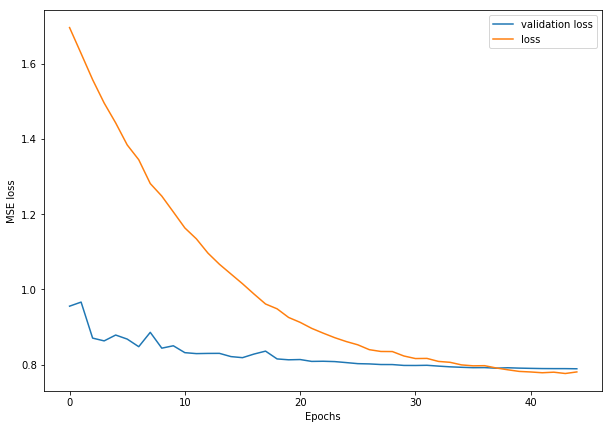

In [51]:
val_loss = deepwide_hist2.history['val_loss'] + deepwide_hist3.history['val_loss'] + deepwide_hist4.history['val_loss'] + deepwide_hist5.history['val_loss'] + deepwide_hist6.history['val_loss'] + deepwide_hist7.history['val_loss']

loss = deepwide_hist2.history['loss'] + deepwide_hist3.history['loss'] + deepwide_hist4.history['loss'] + deepwide_hist5.history['loss'] + deepwide_hist6.history['loss'] + deepwide_hist7.history['loss']    
    
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(val_loss, label = 'validation loss')
plt.plot(loss, label = 'loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()